### Sentiment Analysis and Topic Modeling

In [0]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

# more about reproducing the results: https://machinelearningmastery.com/reproducible-results-neural-networks-keras/

#### Importing the modules

In [0]:
import os
import numpy as np
import pandas as pd

# importing selv-defined functions
from Preprocessing.data_preprocess import preprocessing
from Preprocessing.to_embedding import WordEmbedding
from Preprocessing.helper_functions import *

# for splitting the dataset into train and test set
from sklearn.model_selection import train_test_split

# for undersambling the majority class
from imblearn.under_sampling import RandomUnderSampler

# for data preprocessing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# for data vectorization
from tensorflow.python.keras.preprocessing.text import Tokenizer

# to save the tokenizer
import pickle

# for sentiment analysis model
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, CuDNNLSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint

# to save sentiment analysis model
from keras.models import load_model

# for data visualizations
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import pyLDAvis.gensim
pyLDAvis.enable_notebook()


# Topic modeling with Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel


import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/admin/anaconda3/lib/python3.7/site-packages/thinc/neural/train.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, linear_decay


In [0]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know',
                   'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 
                   'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 
                   'right', 'line', 'even', 'also', 'may', 'take', 'come',
                  'like', 'well', 'point', 'much'])

### 1 Sentiment Analysis

In [0]:
# inspired by this article:
# https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456

#### 1.1 Importing and cleaning the dataset

In [0]:
# link with the dataset: https://www.kaggle.com/omkarsabnis/yelp-reviews-dataset
data_reviews = pd.read_csv("yelp.csv")
data_reviews.head()


,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [0]:
# Reviews with less than 3 stars are considered to be negative
data_reviews['polarity'] = 'positive'
data_reviews.loc[data_reviews['stars'] < 3, 'polarity'] = 'negative'

# we need only text of the review and the polarity
data = data_reviews[['polarity', 'text']].copy()

print(data.head())
print()
print(data['polarity'].unique())

   polarity                                               text
0  positive  My wife took me here on my birthday for breakf...
1  positive  I have no idea why some people give bad review...
2  positive  love the gyro plate. Rice is so good and I als...
3  positive  Rosie, Dakota, and I LOVE Chaparral Dog Park!!...
4  positive  General Manager Scott Petello is a good egg!!!...

['positive' 'negative']


In [0]:
# data preprocessing
data['preprocessed_text'] = preprocessing(data['text'], stop_words)
data.head()

,polarity,text,preprocessed_text
0,positive,My wife took me here on my birthday for breakf...,"[wife, took, birthday, breakfast, excel, weath..."
1,positive,I have no idea why some people give bad review...,"[idea, peopl, give, bad, review, place, goe, s..."
2,positive,love the gyro plate. Rice is so good and I als...,"[love, gyro, plate, rice, dig, candi, select]"
3,positive,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...","[rosi, dakota, love, chaparr, dog, park, conve..."
4,positive,General Manager Scott Petello is a good egg!!!...,"[gener, manag, scott, petello, egg, detail, le..."


In [0]:
# creating a copy of data in case we need it later
data_copy = data.copy()

In [0]:
# splitting into train and test set
y = pd.get_dummies(data['polarity'])
data = data.drop('polarity', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.10, random_state=42)


In [0]:
# checking the umbalance of the classes
print('Reviews in training set: ', len(y_train))
print('Positive reviews in the training set: ', y_train['positive'].sum())
print('Negative reviews in the training set: ', len(y_train) - y_train['positive'].sum())

Reviews in training set:  9000
Positive reviews in the training set:  7474
Negative reviews in the training set:  1526


#### 1.2 Building the dictionary

In [0]:
embedding_size = 300 #number of feature weights in embeddings
max_len = 400 # (lengh of 1 document - important to keep the same number on new reviews as well) 

# creating the instance of selv defined class Embedding
embedding = WordEmbedding(num_features = embedding_size)

# Fitting on the training set (creating the dictionary)
WordEmbedding.fit(embedding, X_train['preprocessed_text'])

# Checking how many words are in the dictionary
WordEmbedding.size(embedding)

Total number of words in the vocabulary:  (6510, 300)


In [0]:
#Save word embedding to dataframe
#train_embeddings = WordEmbedding.to_pd(embedding, X_train)

#Save the dictionary to a file using function of the class
WordEmbedding.to_file(embedding)

In [0]:
# load saved embedding
dictionary = import_embedding('trained_embedding_word2vec.txt')

In [0]:
# dictionary
type(dictionary)

dict

### Optional - balancing the classes

In [0]:
# splitting into train and test set
y = pd.get_dummies(data_copy['polarity'], drop_first = True)
data = data_copy.drop('polarity', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.05, random_state=42)


In [0]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
X_train = pd.DataFrame(X_resampled)
X_train.columns = ['text', 'preprocessed_text']
y_train = pd.DataFrame(y_resampled)
y_train.columns = ['positive']

In [0]:
y_train.head()

,positive
0,0
1,0
2,0
3,0
4,0


In [0]:
y_train['negative'] = 1
y_train.loc[y_train['positive'] == 1, 'negative'] = 0
y_train.head()

,positive,negative
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [0]:
y_test['negative'] = 1
y_test.loc[y_test['positive'] == 1, 'negative'] = 0
y_test.head()

,positive,negative
6252,1,0
4684,1,0
1731,1,0
4742,0,1
4521,1,0


In [0]:
# checking the umbalance of the classes
print('Reviews in training set: ', len(y_train))
print('Positive reviews in the training set: ', y_train['positive'].sum())
print('Negative reviews in the training set: ', y_train['negative'].sum())

Reviews in training set:  3198
Positive reviews in the training set:  1599
Negative reviews in the training set:  1599


#### 1.3 Vectorize the data

In [0]:
#Basic Vectorization of data
# getting the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['preprocessed_text'])
word_index = tokenizer.word_index

X_train = vectorize(X_train['preprocessed_text'], tokenizer , max_len)
X_test = vectorize(X_test['preprocessed_text'], tokenizer, max_len)

print('Found %s unique tokens.' % len(word_index))
print('Shape of train tensor', X_train.shape)
print('Shape of test tensor', X_test.shape)

Found 12184 unique tokens.
Shape of train tensor (3198, 400)
Shape of test tensor (500, 400)


In [0]:
# word_index # uncomment and check out with shift + tab

In [0]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [0]:
# saving tokenizer for vectorizing future data
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


#### 1.4 Create word vectors with the loaded word2vec model

In [0]:
embedding_matrix, num_words = embedding_matrix_word2vec(word_index, embedding_size, dictionary)

In [0]:
# embeding matrix is matrix of all vectors with "number of words" rows and "max_len" columns
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00739852,  0.35675278,  0.24452092, ...,  0.48776016,
        -0.1658654 , -0.24873516],
       [ 0.0686224 ,  0.20469289,  0.23161617, ...,  0.41729456,
        -0.20809829,  0.0463314 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.02130301,  0.06243505,  0.07956874, ...,  0.02057932,
        -0.09300552,  0.00150677],
       [ 0.01110731,  0.02244561,  0.029132  , ...,  0.02191671,
        -0.02743678, -0.0051542 ]])

In [0]:
num_words

12185

### 1.5 Checking train/test sets

In [0]:
print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (3198, 400)
Shape of y_train: (3198, 2)
Shape of X_test: (500, 400)
Shape of y_test: (500, 2)


#### 1.6 Building the model

In [0]:
# Defining Model
model = Sequential()
model.add(Embedding(num_words, 
                    embedding_size,
                    embeddings_initializer = Constant(embedding_matrix),
                    input_length = max_len,
                     dropout=0.2))
model.add(Bidirectional(LSTM(128, return_sequences = True))) #CHANGE LSTM to CuDNNLSTM if Cude is available!
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(2, activation="sigmoid")) # change 2 to 1, in case the y_train and y_test have only one dimension

# ModelCheckpoint is optional
checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_acc',save_best_only=True, mode='auto')

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

W0626 14:18:22.762207 140735978423168 deprecation_wrapper.py:119] From /Users/admin/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0626 14:18:22.765075 140735978423168 deprecation_wrapper.py:119] From /Users/admin/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0626 14:18:22.947471 140735978423168 deprecation_wrapper.py:119] From /Users/admin/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0626 14:18:23.550048 140735978423168 deprecation_wrapper.py:119] From /Users/admin/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placehold

In [0]:
# Fitting Model
history = model.fit(X_train, y_train, batch_size = 256, epochs = 15, validation_data = (X_test, y_test), callbacks=[checkpoint], verbose = 1)

Train on 3198 samples, validate on 500 samples
Epoch 1/15
3198/3198 [==============================] - 166s 52ms/step - loss: 0.6443 - acc: 0.6207 - val_loss: 0.6518 - val_acc: 0.6220

Epoch 00001: val_acc improved from -inf to 0.62200, saving model to model-001-0.620700-0.622000.h5
Epoch 2/15
3198/3198 [==============================] - 154s 48ms/step - loss: 0.5505 - acc: 0.7211 - val_loss: 0.4178 - val_acc: 0.8150

Epoch 00002: val_acc improved from 0.62200 to 0.81500, saving model to model-002-0.721076-0.815000.h5
Epoch 3/15
3198/3198 [==============================] - 156s 49ms/step - loss: 0.4820 - acc: 0.7819 - val_loss: 0.3849 - val_acc: 0.8100

Epoch 00003: val_acc did not improve from 0.81500
Epoch 4/15
3198/3198 [==============================] - 160s 50ms/step - loss: 0.4082 - acc: 0.8271 - val_loss: 0.4110 - val_acc: 0.8090

Epoch 00004: val_acc did not improve from 0.81500
Epoch 5/15
3198/3198 [==============================] - 144s 45ms/step - loss: 0.3459 - acc: 0.8607 

In [0]:
# creating function to plot the modeling results
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

Development Accuracy:  0.9923
Testing Accuracy:  0.8680


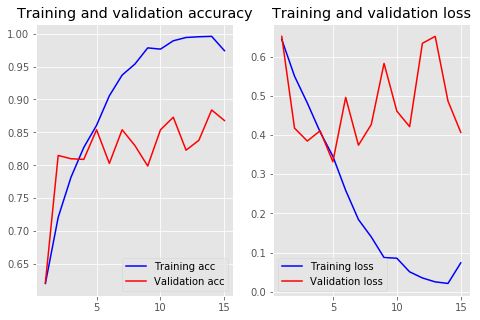

In [0]:
# plotting the model results
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Development Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [0]:
# saving the model in case you don't use ModelCheckpoint
# It is not recommended to use pickle or cPickle to save a Keras model

# model.save('sentiment_analysis_model.h5')  # creates a HDF5 file 'sentiment_analysis_model.h5'

# more saving options:
# https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

### 2 Topic Modeling 

In [0]:
# inspired by this article:
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

#### 2.1 Getting the cleaned data of negative reviews

In [0]:
data_negative = data_reviews[data_reviews['polarity'] == 'negative'].copy().reset_index(drop=True)
corpus = preprocessing(data_negative['text'].copy(), stop_words)
print(corpus[0])

['worth', 'salad', 'small', 'pizza', 'absolut', 'bad', 'servic', 'mayb', 'guy', 'grandma', 'die', 'tell', 'realli', 'made', 'mad', 'experi', 'order', 'small', 'pizza', 'salad', 'guy', 'care', 'less', 'took', 'sat', 'look', 'around', 'hmm', 'sign', 'say', 'x', 'larg', 'pizza', 'larg', 'salad', 'wow', 'guy', 'told', 'us', 'left', 'hungri', 'mad', 'unsatisfi', 'owner', 'teach', 'employe', 'valu', 'upsel', 'tell', 'special', 'someth', 'small', 'affect', 'custom', 'experi', 'neg', 'salad', 'sever', 'overpr', 'back', 'unless', 'desper']


In [0]:
# save corpus
np.savetxt("corpus.csv", corpus, delimiter=",", fmt='%s')

# load previously saved corpus
# corpus = pd.read_csv("corpus.csv", header = None)[0].tolist()


#### 2.2 Building the dictionary

In [0]:
# building the dictionary with gensim.corpora.Dictionary function (to be able to use its visualizations)
dictionary = corpora.Dictionary(corpus)

In [0]:
# save dictionary
dictionary.save_as_text("corpora_dictionary")

In [0]:
dictionary

#### 2.3 Creating the bag of words (corpus in gensim vocabulary)

In [0]:
# Create Corpus: Term Document Frequency (bag of words) as a sparse vector
bag_of_words = [dictionary.doc2bow(text) for text in corpus]

In [0]:
# bag of words for the first document (text) in the corpus
print(bag_of_words[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 3), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 3), (27, 1), (28, 4), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 3), (35, 1), (36, 1), (37, 1), (38, 2), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1)]


#### 2.4 Building the LDA model

In [0]:
# LDA model explained in this article: 

In [0]:
# Building LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=bag_of_words,
                                           id2word=dictionary,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [0]:
# save LDA model
lda_model.save("lda_model")


#### 2.5 Plotting the topic modeling results

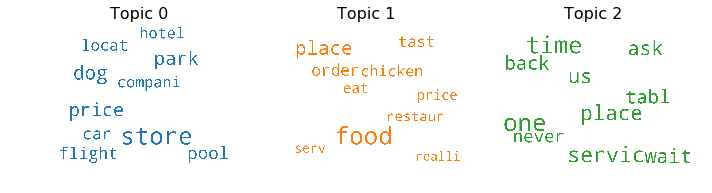

In [0]:
# Wordcloud of Top N words in each topic

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

# adjust number of subplots in case of different number of topics
fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [0]:
#  What is the Dominant topic and its percentage contribution in each document
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bag_of_words, texts=data_negative['text'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.6333,"one, time, servic, place, us, ask, wait, tabl,...",Was it worth the 21$ for a salad and small piz...
1,1,2.0,0.5644,"one, time, servic, place, us, ask, wait, tabl,...",U can go there n check the car out. If u wanna...
2,2,1.0,0.4879,"food, place, order, tast, chicken, eat, restau...",Disgusting! Had a Groupon so my daughter and ...
3,3,1.0,0.6381,"food, place, order, tast, chicken, eat, restau...","I've eaten here many times, but none as bad as..."
4,4,2.0,0.7983,"one, time, servic, place, us, ask, wait, tabl,...",I have to add to Andrew's review.....\n\nI jus...
5,5,2.0,0.9013,"one, time, servic, place, us, ask, wait, tabl,...",I have always been a fan of Burlington's deals...
6,6,2.0,0.9853,"one, time, servic, place, us, ask, wait, tabl,...",Another night meeting friends here. I have to...
7,7,2.0,0.5421,"one, time, servic, place, us, ask, wait, tabl,...",Not busy at all but took nearly 45 min to get ...
8,8,2.0,0.6181,"one, time, servic, place, us, ask, wait, tabl,...","Yikes, reading other reviews I realize my bad ..."
9,9,2.0,0.8086,"one, time, servic, place, us, ask, wait, tabl,...",This is my first year participating in Arizona...


In [0]:
# The most representative sentence for each topic
# Display setting to show more characters in column
pd.options.display.max_colwidth = 500

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.8524,"store, dog, park, price, pool, car, flight, locat, compani, hotel",Highest gas prices in the valley!
1,1.0,0.9886,"food, place, order, tast, chicken, eat, restaur, price, serv, realli","uuuuuugh. What a sorry disappointment of a meal. The BF and I went here for dinner tonight and it was pretty not good. I got the pick two with the balsamic steak 'panini' and the chicken stew. The BF got a turkey 'panini.' Well....his 'panini' was barely toasted, let alone a panini. My sandwich was toasted but the steak was pretty gross....chewy and tasted like it came out of a bag. The tomatoes were mealy. The whole thing was sad. The chicken stew was decent, but had that plastic -y look to..."
2,2.0,0.9937,"one, time, servic, place, us, ask, wait, tabl, back, never","This place is worse than the IRS, at least the IRS admits when they made a mistake. But these arrogant workers will be caught dead before they hear themselves say ""sorry for the inconvenience"" or ""we made a mistake"". They gave me different information on two consecutive visits that I made, then Dorrie, some lady who obviously should not have been working that day because she was coughing phlegm all over my documents, then after she asked me to wait by the counter for 10 minutes while their ..."


Text(0, 0.5, 'Number of Documents')

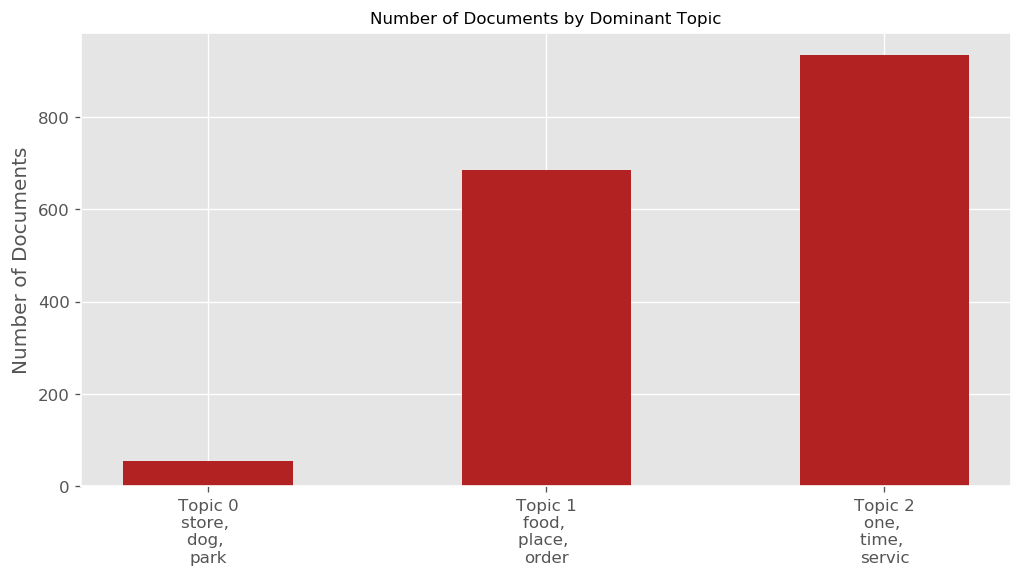

In [0]:
# What are the most discussed topics in the documents?

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=bag_of_words, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()


# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]
df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

from matplotlib.ticker import FuncFormatter

# Plot
fig, ax1 = plt.subplots(figsize=(10, 5), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
#ax1.set_ylim(0, 1000000)

In [0]:
# filtering the complaints about service only from df_dominant_topic dataframe
service_complaints = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2].copy()
service_complaints.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.6333,"one, time, servic, place, us, ask, wait, tabl, back, never","Was it worth the 21$ for a salad and small pizza? Absolutely not! Bad service. Maybe the guys grandma died I don't know. I want to tell you what really made me mad about the experience. We order the small pizza and salad and the guys could have cared less and took our $ and we sat down. We were looking around and hmm, there's a sign saying ""x large pizza and large salad only 23$"". Wow that would have been nice if the guy told us that. I left hungry, mad and unsatisfied. \n\nTo the owner: tea..."
1,1,2.0,0.5644,"one, time, servic, place, us, ask, wait, tabl, back, never","U can go there n check the car out. If u wanna buy 1 there? That's wrong move! If u even want a car service from there? U made a biggest mistake of ur life!! I had 1 time asked my girlfriend to take my car there for an oil service, guess what? They ripped my girlfriend off by lying how bad my car is now. If without fixing the problem. Might bring some serious accident. Then she did what they said. 4 brand new tires, timing belt, 4 new brake pads. U know why's the worst? All of those above I ..."
4,4,2.0,0.7983,"one, time, servic, place, us, ask, wait, tabl, back, never","I have to add to Andrew's review.....\n\nI just can't believe the things that happened!!\n\nYes the app was good. The entree was good too, but there were bites of just bread with no chicken in the panini. It definitely would have been better with more chicken!\n\nBut the girl working here is one of the worst waitress/bartender/hostesses EVER!\n\nWhen we walked in, she didn't even sit us. We stood there forever waiting until she finally told us to seat ourselves. We went outside since the..."
5,5,2.0,0.9013,"one, time, servic, place, us, ask, wait, tabl, back, never","I have always been a fan of Burlington's deals, however I will not be shopping at this one again. I went to return a belt... pretty simple. Instead, I stood in the customer service line for 15 minutes thanks to an employee of Burlington buying/putting things on layaway. It took three other staff to help her out. There were no words said to me except ""Hold on"". I was pissed. When the lady was finally done, the employee at the service asked ""what do you want?"" Serious help is needed there!\n I..."
6,6,2.0,0.9853,"one, time, servic, place, us, ask, wait, tabl, back, never",Another night meeting friends here. I have to laugh. Waited another 20 minutes for my beer to be refilled at the bar. A girl even took my empty without even asking if I wanted a refill. A new brunette girl that I don't recognize left the bar and sat down with her guy friends on the customer side AT 9:25 ON A FRIDAY NIGHT. Another bartender had to ask her to come back and work. Management.... Pull your head out of your ass! Sad to watch.... I need to talk my friends into another place!
7,7,2.0,0.5421,"one, time, servic, place, us, ask, wait, tabl, back, never","Not busy at all but took nearly 45 min to get our meal. Ordered the trout and was shocked to see lots and lots of bones. Hmmmmm. Well asked the waitress about it and she said ""they try the best they can"" hmmmmmm isn't this a ""fish"" restaurant? \nThey comped the trout but still not sure I would go back."
8,8,2.0,0.6181,"one, time, servic, place, us, ask, wait, tabl, back, never","Yikes, reading other reviews I realize my bad experience wasn't unique. As a server I make a very laid back customer. I like pretty much everything I eat and don't require a lot of attention from the waiter. \n\nLa Piccola Cucina would benefit from just one extra person in the front of the house. Our guy, though adorable and friendly, was too busy to refill our drinks and to remember to bring our appetizer (though charged us for it). The ahi tuna (highly recommended over the other fish optio..."
9,9,2.0,0.8086,"one, time, servic, place, us, ask, wait, tabl, back, never","This is my first y